In [1]:
import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### Ground truth

Sizes
  x: (80, 1) 
  y: (80, 1)


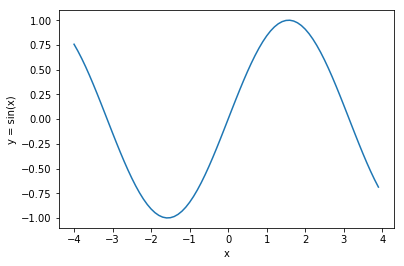

In [55]:
x_np = np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32)
y_np = np.sin(x_np)

print('Sizes\n', ' x:', x_np.shape, '\n  y:', y_np.shape)
plt.plot(x_np, y_np)
plt.ylabel('y = sin(x)')
plt.xlabel('x')
plt.show()

### Parameter initialization

In [4]:
r_dim = 2
z_dim = 2
h_specs = [(8, torch.nn.ReLU()), (r_dim, None)]
g_specs = [(8, torch.nn.Sigmoid()), (y_np.shape[1], None)]
h_input_dim = x_np.shape[1] + y_np.shape[1]
g_input_dim = x_np.shape[1] + z_dim

In [70]:
h = nep.Encoder(h_input_dim, h_specs)
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(g_input_dim, g_specs)
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), lr=1e-3)

### Training

In [71]:
epochs = 2000
n_z_samples = 10
losses = []
kl = []
nll = []

for epoch in range(epochs):
    optimizer.zero_grad()
    n_context = np.random.randint(1,4)
    x_c, y_c, x_t, y_t = nep.randsplit_totensor(x_np, y_np, n_context)
    x_all = torch.from_numpy(x_np)
    y_all = torch.from_numpy(y_np)

    xy_all = torch.cat([x_all, y_all], dim=1)
    z_mean_all, z_logvar_all = r_to_z(h(xy_all))
    z_std_all = torch.exp(0.5 * z_logvar_all)
    #z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, how_many=1)
    #xz_all = torch.cat([x_c, z_sample_c.expand(x_c.shape[0], -1)], dim=1)

    xy_c = torch.cat([x_c, y_c], dim=1)
    z_mean_c, z_logvar_c = r_to_z(h(xy_c))
    z_std_c = torch.exp(0.5 * z_logvar_c)
    
    #need 10 sample for MC approximation of the log_likelihood
    z_sample_c = nep.sample_z(z_mean_c, z_logvar_c, how_many=n_z_samples)
    z_sample_c_reshaped = z_sample_c.unsqueeze(1).expand(-1, x_t.shape[0], -1)
    x_t_reshaped = x_t.unsqueeze(0).expand(z_sample_c.shape[0], x_t.shape[0], x_t.shape[1])
    xz_t = torch.cat([x_t_reshaped, z_sample_c_reshaped], dim=2)

    mean, logvar = g(xz_t)
    mean_mc = mean.squeeze(-1) 
    logvar_mc = torch.ones_like(mean_mc) * logvar
    std_mc = torch.exp(0.5 * logvar_mc)

    NLL = nep.neg_loglik(mean_mc, std_mc, y_t)
    KL = nep.KL_div(z_mean_c, z_std_c, z_mean_all, z_std_all)

    loss = NLL + KL
    losses.append(loss)
    kl.append(KL)
    nll.append(NLL)
    
    loss.backward()
    optimizer.step()

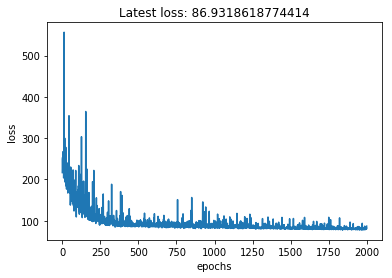

In [72]:
plt.plot(losses)
plt.title('Latest loss: {}'.format(losses[-1]))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

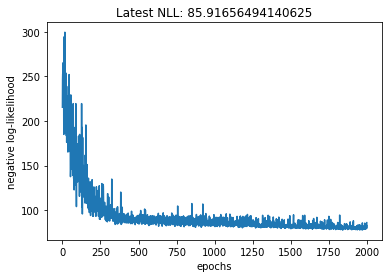

In [73]:
plt.plot(nll)
plt.title('Latest NLL: {}'.format(nll[-1]))
plt.xlabel('epochs')
plt.ylabel('negative log-likelihood')
plt.show()

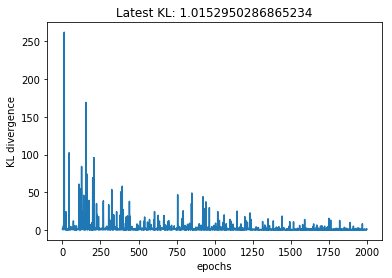

In [74]:
plt.plot(kl)
plt.title('Latest KL: {}'.format(kl[-1]))
plt.xlabel('epochs')
plt.ylabel('KL divergence')
plt.show()

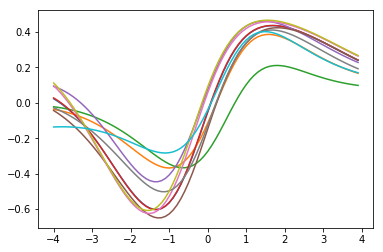

In [75]:
z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, how_many=10)
zs = z_sample_all.unsqueeze(1).expand(-1, x_all.shape[0], -1)
xs = x_all.unsqueeze(0).expand(z_sample_all.shape[0], x_all.shape[0], x_all.shape[1])
xzs = torch.cat([xs, zs], dim=2)
for i in range(xzs.shape[0]):
    mean_y, _ = g(xzs[i])
    plt.plot(x_all.numpy(), mean_y.detach().numpy())


In [108]:
zs = z.unsqueeze(1).expand(-1, x_t.shape[0], -1)
xs = x_t.unsqueeze(0).expand(z.shape[0], x_t.shape[0], x_t.shape[1])
input_xz = torch.cat([xs, zs], dim=2)
m,_ = g(input_xz)
m.shape, input_xz.shape

(torch.Size([10, 5, 1]), torch.Size([10, 5, 3]))